In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
zip_file_path = 'archive.zip'
extract_to_dir = 'pokemon/data'

In [4]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

In [5]:
base_dir = 'pokemon/data/dataset'

Pre-Process data. resize, normalize, split into training/validation sets

In [3]:
# Initialize the ImageDataGenerator for data normalization and augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)# Use 20% of the data for validation

In [6]:
# Prepare training and validation generators
train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),  # Resize images
        batch_size=32,
        class_mode='categorical',
        subset='training')  # Set as training data

validation_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        subset='validation')  # Set as validation data

Found 16456 images belonging to 150 classes.
Found 4035 images belonging to 150 classes.


Design Model : Convolutional Neural Network (CNN) 

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(512, activation='relu'),
    layers.Dense(150, activation='softmax')  # 150 classes for Gen 1 Pokémon
])

# Model summary
model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

Train Model with training/validation generators 

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,  # Adjust based on your dataset size
    epochs=100,  # Adjust based on convergence
    validation_data=validation_generator,
    validation_steps=50)  # Adjust based on your dataset size


Epoch 1/100
 46/100 [============>.................] - ETA: 16s - loss: 4.9885 - accuracy: 0.0166

C:\Users\dewdr\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


100/100 [==============================] - 50s 501ms/step - loss: 4.9180 - accuracy: 0.0205 - val_loss: 4.6943 - val_accuracy: 0.0338
Epoch 2/100
100/100 [==============================] - 50s 498ms/step - loss: 4.6419 - accuracy: 0.0394 - val_loss: 4.3948 - val_accuracy: 0.0437
Epoch 3/100
100/100 [==============================] - 48s 478ms/step - loss: 4.4713 - accuracy: 0.0551 - val_loss: 4.1995 - val_accuracy: 0.0681
Epoch 4/100
100/100 [==============================] - 48s 485ms/step - loss: 4.3511 - accuracy: 0.0616 - val_loss: 4.0874 - val_accuracy: 0.0881
Epoch 5/100
100/100 [==============================] - 46s 465ms/step - loss: 4.2457 - accuracy: 0.0768 - val_loss: 3.8499 - val_accuracy: 0.0938
Epoch 6/100
100/100 [==============================] - 48s 480ms/step - loss: 4.0184 - accuracy: 0.1000 - val_loss: 3.6725 - val_accuracy: 0.1281
Epoch 7/100
100/100 [==============================] - 48s 482ms/step - loss: 3.8754 - accuracy: 0.1203 - val_loss: 3.3989 - val_accurac

Evaluate Model using validation set

In [11]:
# Evaluate the model
val_loss, val_acc = model.evaluate(validation_generator, steps=50)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')


50/50 [==============================] - 16s 320ms/step - loss: 1.3185 - accuracy: 0.6619
Validation loss: 1.3184857368469238, Validation accuracy: 0.6618750095367432


In [12]:
model.save('model.keras')

In [13]:
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Make it a batch of one
    img_array /= 255.0  # Rescale pixel values to match training
    return img_array

image_path = '025.png'  # Adjust with the path to your image
img_array = load_and_preprocess_image(image_path)


In [14]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Assuming you have a mapping of class indices to Pokémon names
pokemon_names = list(train_generator.class_indices.keys())  # Get Pokémon names
predicted_pokemon = pokemon_names[predicted_class[0]]
print(f"This image is most likely: {predicted_pokemon} with a probability of {np.max(predictions)}")


1/1 [==============================] - 0s 74ms/step
This image is most likely: Pikachu with a probability of 0.7355995178222656


In [15]:
# Assuming train_generator is already defined and used for training
pokemon_indices = train_generator.class_indices
pokemon_names = list(pokemon_indices.keys())  # Extracting Pokémon names from the indices

# Printing the mapping of class index to Pokémon name
for pokemon, index in pokemon_indices.items():
    print(f"Index: {index}, Pokémon: {pokemon}")


Index: 0, Pokémon: Abra
Index: 1, Pokémon: Aerodactyl
Index: 2, Pokémon: Alakazam
Index: 3, Pokémon: Arbok
Index: 4, Pokémon: Arcanine
Index: 5, Pokémon: Articuno
Index: 6, Pokémon: Beedrill
Index: 7, Pokémon: Bellsprout
Index: 8, Pokémon: Blastoise
Index: 9, Pokémon: Bulbasaur
Index: 10, Pokémon: Butterfree
Index: 11, Pokémon: Caterpie
Index: 12, Pokémon: Chansey
Index: 13, Pokémon: Charizard
Index: 14, Pokémon: Charmander
Index: 15, Pokémon: Charmeleon
Index: 16, Pokémon: Clefable
Index: 17, Pokémon: Clefairy
Index: 18, Pokémon: Cloyster
Index: 19, Pokémon: Cubone
Index: 20, Pokémon: Dewgong
Index: 21, Pokémon: Diglett
Index: 22, Pokémon: Ditto
Index: 23, Pokémon: Dodrio
Index: 24, Pokémon: Doduo
Index: 25, Pokémon: Dragonair
Index: 26, Pokémon: Dragonite
Index: 27, Pokémon: Dratini
Index: 28, Pokémon: Drowzee
Index: 29, Pokémon: Dugtrio
Index: 30, Pokémon: Eevee
Index: 31, Pokémon: Ekans
Index: 32, Pokémon: Electabuzz
Index: 33, Pokémon: Electrode
Index: 34, Pokémon: Exeggcute
Index

In [16]:
import json

# Assuming 'train_generator' is your training image data generator
class_indices = train_generator.class_indices

# Convert the class indices to a dictionary with classes as keys and indices as values
index_to_class_dict = {v: k for k, v in class_indices.items()}

# Now, save this dictionary to a JSON file
with open('class_indices.json', 'w') as json_file:
    json.dump(index_to_class_dict, json_file)

# The JSON file is now saved in the writable directory of this environment, you can download it
print("JSON file containing class indices has been saved!")


JSON file containing class indices has been saved!


1/1 [==============================] - 0s 42ms/step


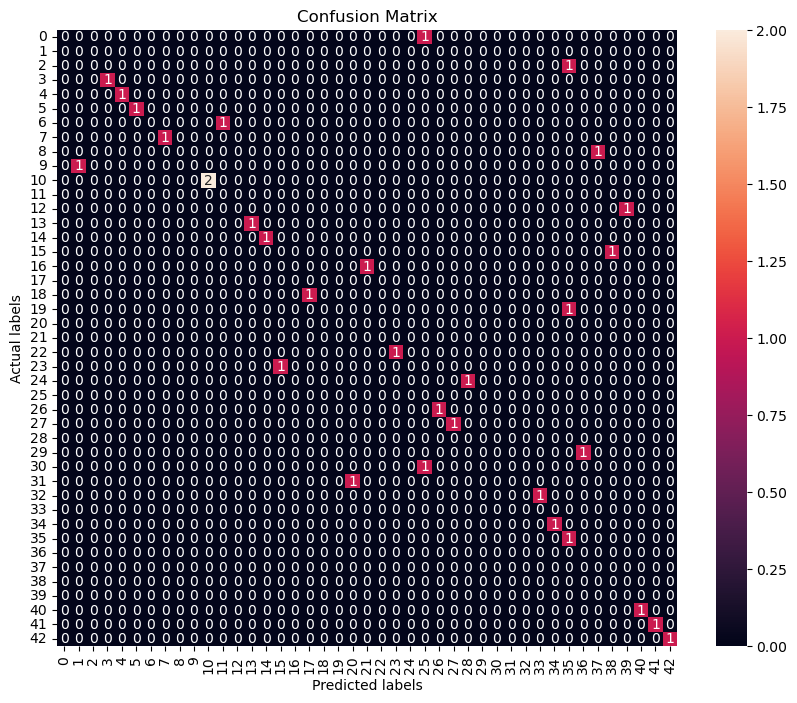

In [17]:
# Fetch validation data and labels from the generator
validation_images, validation_labels = next(validation_generator)

# Get predictions for the validation set
predictions = model.predict(validation_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(validation_labels, axis=1)

# Generate a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("Actual labels")
plt.xlabel("Predicted labels")
plt.show()


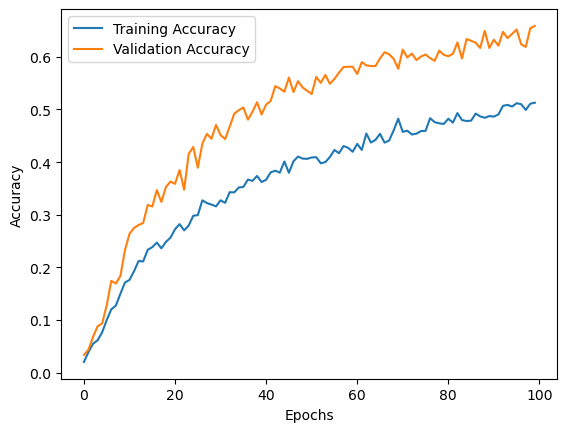

In [18]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
